In this final notebook for this project, I will be building the model and evaluating it's performance.

#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

#Retrieving Data

In [ ]:
df = pd.read_csv("final_bioactivity_data.csv")

In [ ]:
df.head()

,MW,LogP,NumHDonors,NumHAcceptors,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,...,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023,bioactivity_class
0,383.814,4.45034,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,482.903,3.61432,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,283.287,2.31056,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,164.160,1.49000,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,215.168,1.73096,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
df.shape

(1239, 1029)

#Installing Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 20.2 MB/s eta 0:00:00


Optuna is an automatic hyperparameter optimization framework that helps efficiently search for the best model settings using techniques like Bayesian optimization. I will be using it later to fine-tune the machine learning model for improved performance.

#**Model Setup & Feature–Label Separation**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import f1_score, make_scorer
import optuna

X = df.drop("bioactivity_class", axis=1)
y = df["bioactivity_class"]

#**Imports Explained**

#RandomForestClassifier

- A powerful, ensemble learning method that builds multiple decision trees and outputs the mode of their predictions.

- Handles both categorical and continuous features.

- Does not require feature scaling or normalization.

- Naturally handles non-linear relationships, outliers, and imbalanced features.

- Perfect fit for my bioactivity data with mixed descriptors and fingerprint bits.

#StratifiedKFold

- A type of cross-validation that maintains the original class distribution in each fold (important because my dataset is imbalanced, with far more actives than inactives).

- Prevents performance inflation due to overrepresentation of the majority class in certain folds.

- Essential when using metrics like F1 score.

#train_test_split

- Splits your data into training and test sets.

- Typically used before final evaluation.

- Allows to hold out a test set that the model has never seen, providing unbiased performance metrics after tuning.

#cross_val_score

- Automates the training and evaluation of models over K folds.

- Will be used to compute an average metric (like F1 score) over multiple validation splits.

- Helps in avoiding lucky/unlucky splits by validating across the entire dataset.

- f1_score

The F1 score is the harmonic mean of precision and recall:

F1
=
2
×
(Precision
⋅
Recall)/
(Precision
+
Recall)

I am using this because of class imbalance:

- Accuracy might look high even if the model only predicts the dominant class (e.g., always predicting "active").

- F1 ensures that both false positives and false negatives are penalized.

- It is particularly valuable when the cost of misclassification is non-symmetric, like here (false active > false inactive).

#make_scorer

- Converts a scoring function (like f1_score) into a callable object that can be passed into cross_val_score or Optuna’s objective function.

- This allows custom scoring metrics to be used in CV and hyperparameter tuning.

In [ ]:
print(X.shape)
print(y.shape)

(1239, 1028)
(1239,)


X (features): Includes 1028 columns — 4 physicochemical properties (MW, LogP, etc.) and 1024 Morgan fingerprint bits.

y (target): A binary variable:

1: Active (IC50 ≤ 1000 nM)

0: Inactive (IC50 ≥ 10000 nM)

This separation is the foundation of supervised learning, where X is used to learn patterns that predict y.

#**Nested Cross-Validation with Optuna**

In this section, I perform nested cross-validation to obtain an unbiased estimate of the model’s generalization performance. The process involves two loops:

- Inner loop (3-fold CV): Used by Optuna to tune the hyperparameters of the Random Forest model on each training split.

- Outer loop (5-fold CV): Used to evaluate the model with tuned parameters on a completely unseen test fold.

This setup ensures that hyperparameter optimization is strictly confined to the training data in each split, thereby avoiding data leakage and overly optimistic evaluation metrics.

**I am using F1-score as the evaluation metric to account for class imbalance in the dataset**. The make_scorer function is used to pass this metric to cross_val_score.

Its important to note that this nested CV process is not for deployment, but rather for fairly checking the generalizability of the model pipeline.

In [ ]:
def objective(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=inner_cv, scoring="f1", n_jobs=-1)
    return np.mean(scores)

In [ ]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=25)

    best_params = study.best_params
    best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_test)
    f1 = f1_score(y_test, preds)
    outer_scores.append(f1)

print(f"Nested CV F1-score: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")

[I 2025-06-17 14:40:45,264] A new study created in memory with name: no-name-32f4b668-51b1-4e57-9a0e-b7cd3ebd2571
[I 2025-06-17 14:40:50,295] Trial 0 finished with value: 0.9272051264270944 and parameters: {'n_estimators': 659, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 0 with value: 0.9272051264270944.
[I 2025-06-17 14:40:54,382] Trial 1 finished with value: 0.9393671660474041 and parameters: {'n_estimators': 633, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 1 with value: 0.9393671660474041.
[I 2025-06-17 14:40:59,242] Trial 2 finished with value: 0.9339757939635037 and parameters: {'n_estimators': 986, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 1 with value: 0.9393671660474041.
[I 2025-06-17 14:41:04,324] Trial 3 finished with value: 0.9372433873976272 and parameters: {'n_estimators': 846, 'max_depth': 19, 'min_samples_split

Nested CV F1-score: 0.9405 ± 0.0070


#Nested CV Results and Critical Reflection

- The nested cross-validation yielded an F1-score of 0.9405 ± 0.0070, which at first glance suggests that the model is highly predictive.

- However, a **critical oversight** was identified: the class_weight='balanced' parameter was not included during Optuna’s hyperparameter tuning. Given the class imbalance in the dataset, this likely skewed the model to favor the majority class, resulting in an overly optimistic F1-score.

- While nested cross-validation is widely regarded as one of the most robust techniques for model evaluation—helping avoid data leakage and overfitting—its effectiveness depends on correctly modeling the real-world data context, including handling class imbalance. In this case, its estimate was less realistic because the model was not class-balanced during tuning.

- **I had initially assumed that using StratifiedKFold alone would mitigate the imbalance.** But this experience clearly highlights that incorporating class_weight='balanced' is crucial throughout the entire modeling pipeline, including tuning and validation. This realization was an important learning point and led to improved downstream performance when class balancing was applied consistently.

#Final Model Training with Class Weighting Considered

- To address the limitations of the nested cross-validation approach, I now explicitly handle the class imbalance during model training and evaluation.

- I perform an 80/20 train-test split using stratification to maintain the original class ratio in both training and test sets. This helps ensure that the minority class is well represented in both subsets.

#Optuna for Hyperparameter Optimization

I define an objective function to guide Optuna's hyperparameter search for the RandomForestClassifier. A 5-fold StratifiedKFold cross-validation is used for internal scoring, optimizing the F1-score—a metric well-suited for imbalanced classification problems.

#Best Model Selection

After running 25 trials of optimization, the best hyperparameters are selected:

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 5, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        random_state=42,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1).mean()
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1, class_weight='balanced')
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
final_f1 = f1_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("F1 Score on Test Set:", final_f1)
print("Classification report on Test Set:", classification_report(y_test, y_pred))
print("Feature Importances:", best_model.feature_importances_)

[I 2025-06-18 09:36:26,630] A new study created in memory with name: no-name-93fd20ac-50b8-4b17-aeb5-65b9301b7c33
[I 2025-06-18 09:36:34,413] Trial 0 finished with value: 0.9373497979199634 and parameters: {'n_estimators': 364, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9373497979199634.
[I 2025-06-18 09:36:39,029] Trial 1 finished with value: 0.9368241997228463 and parameters: {'n_estimators': 291, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9373497979199634.
[I 2025-06-18 09:36:41,931] Trial 2 finished with value: 0.9365094517116056 and parameters: {'n_estimators': 266, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9373497979199634.
[I 2025-06-18 09:37:08,826] Trial 3 finished with value: 0.9329872351744852 and parameters: {'n_estimators': 392, 'max_depth': 6, 'min

Best Hyperparameters: {'n_estimators': 105, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
F1 Score on Test Set: 0.9432098765432099
Classification report on Test Set:               precision    recall  f1-score   support

           0       0.71      0.79      0.75        43
           1       0.95      0.93      0.94       205

    accuracy                           0.91       248
   macro avg       0.83      0.86      0.85       248
weighted avg       0.91      0.91      0.91       248

Feature Importances: [1.29741516e-02 1.55628191e-02 6.56149059e-03 ... 9.57726397e-05
 1.65778778e-03 4.16164596e-04]


#Final Model Performance (with class_weight='balanced')

After tuning hyperparameters and incorporating class_weight='balanced' to address class imbalance, the final model was evaluated on the test set:

- Metric	  Class 0 (Inactive)	    Class 1 (Active)
Precision
       0.71	                   0.95
Recall
       0.79	                    0.93
F1-score
       0.75	                     0.94
Support
       43	                        205



Overall Accuracy: 91%

Macro Avg F1-score: 0.85

Weighted Avg F1-score: 0.91

#Interpretation for metrics:

The model now performs much more fairly across both classes.

Even the minority class (inactive compounds) achieves a respectable F1-score of 0.75, indicating that the model is no longer biased towards the majority class.

This improvement validates the use of class_weight="balanced" as a crucial step in real-world bioactivity prediction tasks.

#Interpretation for the Classifier:

The best hyperparameters obtained through Optuna tuning were: {
  'n_estimators': 105,
  'max_depth': 12,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'log2'
}

#These settings provide several insights into how the model is making decisions:

- **max_features='log2'**: Instead of using all 1028 features at each split, the model selects a logarithmic subset, helping to reduce overfitting and introducing beneficial randomness across trees. This also means not all features are evaluated in every tree, which is computationally efficient and promotes feature diversity.

- **max_depth=12 with min_samples_split=2 and min_samples_leaf=1**: These values allow for very deep and detailed trees, capable of capturing intricate patterns in the data. Such configurations suggest the model is building dense trees with high capacity to fit complex structures, which is something especially useful in molecular data with rich substructure information.

- **n_estimators=105**: A relatively moderate number of trees was enough to achieve strong performance, indicating that the model converged quickly and didn’t need an excessively large ensemble.

Overall, these hyperparameters reflect a model that is structurally complex but efficiently optimized, balancing depth and feature randomness to generalize well across a challenging, imbalanced dataset.

In [ ]:
import matplotlib.pyplot as plt

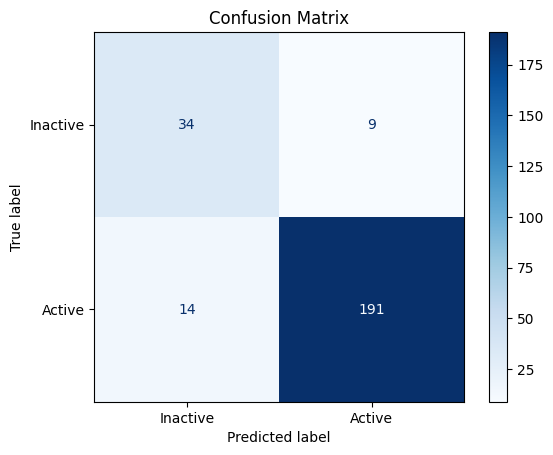

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Inactive", "Active"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show();

#Confusion Matrix Interpretation

- True Positives (Active correctly predicted as Active): 191

- True Negatives (Inactive correctly predicted as Inactive): 34

- False Negatives (Active incorrectly predicted as Inactive): 14

- False Positives (Inactive incorrectly predicted as Active): 9

#Summary:

- The model correctly classified 225 drugs.
- However, 14 active compounds were missed, and 9 inactive compounds were falsely predicted as active.

* Despite these errors, the model demonstrates strong generalization with balanced performance across both classes, thanks to class weighting and robust hyperparameter tuning.

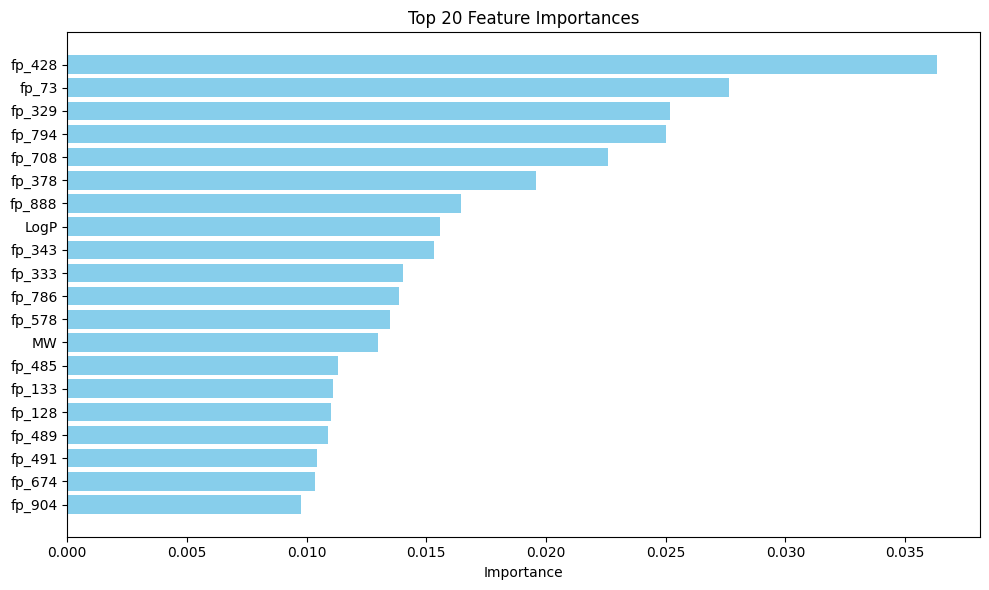

In [ ]:
original_columns = df.columns.drop("bioactivity_class")

importances = best_model.feature_importances_
indices = np.argsort(importances)[-20:]
top_features = original_columns[indices]
top_importances = importances[indices]
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show();

#Feature Importance Analysis

Among the top 20 most important features used by the Random Forest model:

- LogP ranked 8th

- Molecular Weight (MW) ranked 13th

- The remaining 18 features were Morgan fingerprint bits, indicating that structural information derived from molecular topology played a dominant role in classification.

#Insight:
While physicochemical properties contributed meaningfully, molecular fingerprints were the primary drivers of predictive performance, highlighting the importance of substructural features in EGFR bioactivity prediction.

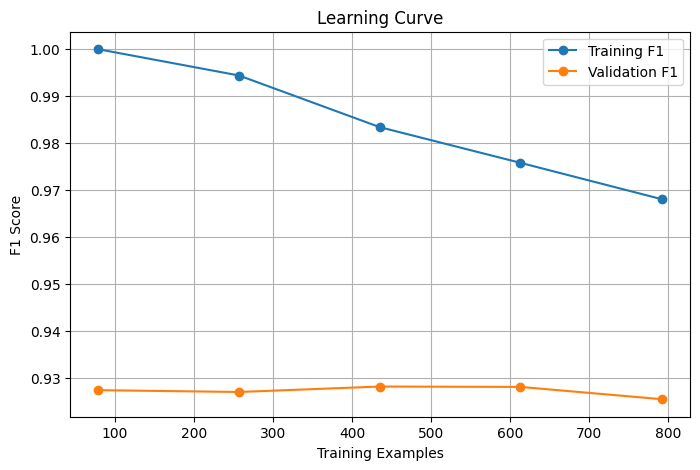

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training F1")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation F1")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show();

#Learning Curve Analysis
A learning curve is a diagnostic tool that plots the model’s performance on the training and validation sets as the training dataset size increases. It helps assess:

- Whether the model is overfitting (high training performance, low validation performance),

- Underfitting (low performance on both), or

- Well-generalized (high and close training and validation performance).

#In this project:

- The training F1-score levels off around 97%

- The validation F1-score stabilizes near 92.5%

#Interpretation
These results indicate that the model:

- Learns well from the data, as both training and validation scores are high.

- Shows a small but healthy generalization gap (~4%), which is expected and suggests that the model is not overfitting.

- Performs consistently across different training sizes, reinforcing the robustness of the chosen features and hyperparameters.

#Conclusion:
The learning curve confirms that the model is well-fitted and generalizes effectively, with strong predictive performance even when class imbalance and chemical diversity are taken into account.

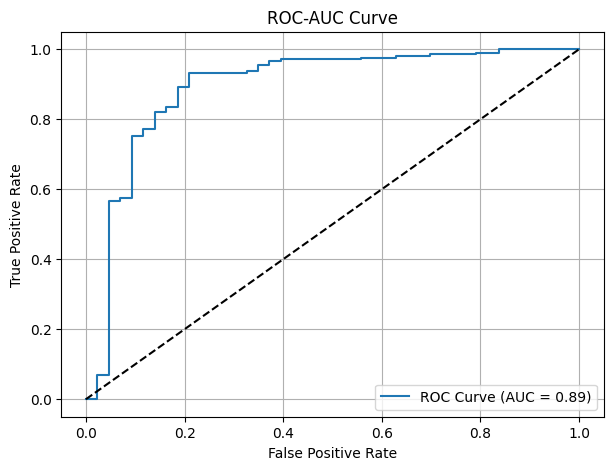

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid(True)
plt.show();

#ROC-AUC Curve Analysis
The ROC (Receiver Operating Characteristic) curve is a plot that illustrates the true positive rate (sensitivity) against the false positive rate (1 - specificity) at various threshold settings.

The AUC (Area Under Curve) summarizes this curve into a single value between 0 and 1, where:

- 1.0 indicates a perfect classifier.

- 0.5 suggests random guessing.

- Anything greater than 0.9 is considered excellent.

#Model Evaluation
For my trained Random Forest model:

- The AUC = 0.89, which means the model has a high ability to distinguish between active and inactive drugs.

- This score further confirms the strong performance previously observed through the F1-score, confusion matrix, and learning curve.

- Despite the class imbalance, the model maintains high discriminative power, thanks to effective tuning and class weighting.

#**Final Evaluation & Reflections**

- The final model, trained with class balancing and tuned hyperparameters, achieved a strong F1-score of 0.94 on the hold-out test set. With a recall of 0.93 for the active class and an F1-score of 0.75 for the inactive class, the model now performs much more fairly across both classes. The confusion matrix (TP=191, TN=34, FP=9, FN=14) also shows reduced bias compared to earlier versions.

- These results reflect the critical importance of using class_weight='balanced' in both the tuning and evaluation phases. Initially, this was omitted during nested cross-validation, which led to over-optimistic performance. This experience highlighted that even robust tools like nested CV need to be carefully designed to reflect real-world settings, underscoring the value of thinking beyond metrics.

#**Key Insights**

- Fingerprint bits dominated the feature importance rankings, reaffirming the value of substructure-driven modeling in cheminformatics.

- Physicochemical features like LogP and Molecular Weight still played significant roles, showing that combining structural and classical descriptors remains valuable.

- Model interpretation not only improves trust but also helps identify molecular traits tied to activity—useful for downstream drug discovery efforts.

#**Learnings**

- Model evaluation must match modeling intent: good CV scores alone don’t guarantee generalization.

- Balancing class distribution during both training and tuning is essential for meaningful, fair performance.

- Simplicity in models like Random Forests can go a long way with thoughtful data preparation and evaluation design.

#**Potential Future Work**

- Explore multitask learning to predict across multiple kinase targets.

- Integrate 3D descriptors or docking features for more nuanced modeling.

- Use conformal prediction or uncertainty estimates to prioritize predictions.

- Investigate false positives and negatives to improve feature space or flag candidates for re-testing. Currently, I lack the biological expertise to do this myself, but will surely try it out once I am comfort more with cheminformatics.


**If anyone going through this notebook have any suggestions, ideas, or improvements, I would genuinely love to hear them. This is still a learning journey, a feedback would be incredibly valuable.**

**Thank you for reading!** 🙏